Code using mlxtend library to find the assoication rules with fp-growth

Movie Rating:  5
Number of frequent sets: 109
Number of rules: 19
               antecedents             consequents  antecedent support  \
0              (tt0080684)             (tt0076759)            0.131148   
1   (tt0076759, tt0133093)             (tt0080684)            0.073770   
2   (tt0133093, tt0080684)             (tt0076759)            0.068852   
3   (tt0076759, tt0082971)             (tt0080684)            0.067213   
4   (tt0082971, tt0080684)             (tt0076759)            0.060656   
5              (tt0086190)             (tt0076759)            0.106557   
6              (tt0086190)             (tt0080684)            0.106557   
7   (tt0076759, tt0086190)             (tt0080684)            0.083607   
8   (tt0086190, tt0080684)             (tt0076759)            0.075410   
9              (tt0120737)             (tt0167260)            0.101639   
10             (tt0167260)             (tt0120737)            0.086885   
11             (tt0167261)             (tt0120

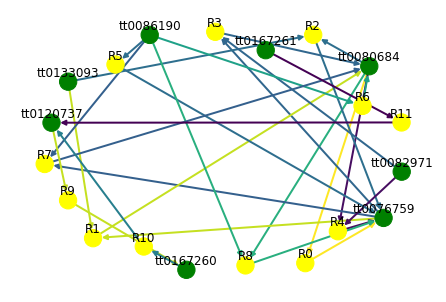

In [69]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth
from time import perf_counter
import pickle_manager
from mlxtend.frequent_patterns import association_rules
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

#Load data into item sets
df = pickle_manager.load_pickle("..\pickles\organised_ratings.pickle.lz4")

for x in range(5,6):
    print("Movie Rating: ", x)
    dataSet = []
    for i in range(1,df['userId'].max()+1):
        itemSet = df.loc[(df['rating'] == x) & (df['userId'] == i)]['imdbId'].tolist()
        dataSet.insert(0,itemSet)

    #Transform the data into the correct format for the libary
    te = TransactionEncoder()
    te_ary = te.fit(dataSet).transform(dataSet)
    new_df = pd.DataFrame(te_ary, columns=te.columns_)

    #Find the frequent pattern sets and generate the assoication rules
    frequent_itemsets = fpgrowth(new_df, min_support=0.05,use_colnames=True)
    #print(frequent_itemsets.sort_values('support',ascending=False))
    print("Number of frequent sets:", len(frequent_itemsets))
    if(len(frequent_itemsets) > 0):
        rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.7)
        print("Number of rules:", len(rules))
        rules.to_csv('rules_library.csv', index=False)

def draw_graph(rules, rules_to_show):
  G1 = nx.DiGraph()
   
  color_map=[]
  N = 50
  colors = np.random.rand(N)    
  strs=['R0', 'R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8', 'R9', 'R10', 'R11']   
   
   
  for i in range (rules_to_show):      
    G1.add_nodes_from(["R"+str(i)])
    
     
    for a in rules.iloc[i]['antecedents']:
                
        G1.add_nodes_from([a])
        
        G1.add_edge(a, "R"+str(i), color=colors[i] , weight = 2)
       
    for c in rules.iloc[i]['consequents']:
             
            G1.add_nodes_from([c])
            
            G1.add_edge("R"+str(i), c, color=colors[i],  weight=2)
 
  for node in G1:
       found_a_string = False
       for item in strs: 
           if node==item:
                found_a_string = True
       if found_a_string:
            color_map.append('yellow')
       else:
            color_map.append('green')       
 
 
   
  edges = G1.edges()
  colors = [G1[u][v]['color'] for u,v in edges]
  weights = [G1[u][v]['weight'] for u,v in edges]
 
  pos = nx.spring_layout(G1, k=16, scale=1)
  nx.draw(G1, pos, node_color = color_map, edge_color=colors, width=weights, font_size=16, with_labels=False)            
   
  for p in pos:  # raise text positions
           pos[p][1] += 0.07
  nx.draw_networkx_labels(G1, pos)
  plt.show()

print(rules)
draw_graph(rules, 12)  


Custome implmnetation of fp-growth and assoication rule finding

In [24]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth
import pickle_manager
from mlxtend.frequent_patterns import association_rules

pd.set_option('display.max_rows', 500)

#Load data into item sets
df = pickle_manager.load_pickle("..\pickles\organised_ratings.pickle.lz4")


results_df = pd.DataFrame(columns=['Implementation','Number of Frequent Sets', 'Support Values', 'Movie ratings'])

for y in range(1,11):
    resultsX1 = []
    resultsY1 = []
    for x in range(1,6):
        dataSet = []
        for i in range(1,df['userId'].max()+1):
            itemSet = df.loc[(df['rating'] == x) & (df['userId'] == i)]['imdbId'].tolist()
            dataSet.insert(0,itemSet)
        #Transform the data into the correct format for the libary
        te = TransactionEncoder()
        te_ary = te.fit(dataSet).transform(dataSet)
        new_df = pd.DataFrame(te_ary, columns=te.columns_)
        #Find the frequent pattern sets and generate the assoication rules
        support = 0.01*y
        #print("Support Percentage", support)
        frequent_itemsets = fpgrowth(new_df, min_support=support,use_colnames=True)
        if(len(frequent_itemsets) > 0):
            rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.7)
        new_row = {'Implementation': "Library", "Number of Frequent Sets": len(frequent_itemsets), "Support Values": support, "Movie ratings":x}
        results_df = results_df.append(new_row, ignore_index=True)




import itertools
import pickle_manager

class Node:
    def __init__(self,item,parent,count = 1):
        self.parent = parent
        self.children = {}
        self.item = item
        self.count = count
        self.link = None

    def addNode(self,item, count = 1):
        if(self.item == item):
            self.count = self.count + count
        else:
            self.children[item] = Node(item,self, count)

class Tree:
    def __init__(self, itemSetList, frequency, minSupport):
        self.root = Node(None,None)
        self.headerTable = {}
        self.createTree(itemSetList, frequency, minSupport)

    def createTree(self,itemSetList,frequency, minSupport):
        #Create header table with each item and count frequcny of each
        i = 0
        for itemSet in itemSetList:
            for item in itemSet:
                if(item in self.headerTable):
                    self.headerTable[item] = [self.headerTable[item][0] + frequency[i], None]
                else:
                    self.headerTable[item] = [frequency[i], None]
            i=i+1

        for k in list(self.headerTable.keys()):
            if self.headerTable[k][0] < minSupport:
                del self.headerTable[k]

        i = 0
        for itemSet in itemSetList:
            itemSet = [item for item in itemSet if item in self.headerTable]
            itemSet.sort(key=lambda item: self.headerTable[item][0], reverse=True)
            self.insertItemSet(itemSet, frequency[i])
            i=i+1


    def insertItemSet(self,items,count):
        currentNode = self.root
        while(len(items) != 0):
            if(items[0] in currentNode.children):
                currentNode = currentNode.children[items[0]]
                currentNode.addNode(items[0], count)
                items.pop(0)
            else:
                currentNode.addNode(items[0], count)
                #If item already in the header table then follow the links to the next slot
                currentItem = self.headerTable[items[0]][1] 
                if(currentItem == None):
                    self.headerTable[items[0]][1] = currentNode.children[items[0]]
                else:
                    while(1):
                        if(currentItem.link == None):
                            currentItem.link = currentNode.children[items[0]]
                            break
                        else:   
                            currentItem = currentItem.link   
                currentNode = currentNode.children[items[0]]
                items.pop(0)

    def traverseToRoot(self,node,branch):
        branch.insert(0,node.item)
        if(node.parent == self.root):
            return branch
        else:
            return self.traverseToRoot(node.parent,branch)

            
    def printTree(self, root, level):
        print("  " * level, root.item, ":", root.count)
        for child in root.children:
            self.printTree(root.children[child],level + 1)

    def getAllPaths(self, item):
        allPaths = []
        currentNode = self.headerTable[item][1]
        while(1):
            branch = []
            self.traverseToRoot(currentNode,branch)
            branch.remove(item)
            if(currentNode.link == None):
                if(len(branch) > 0):
                    allPaths.insert(0,(branch,currentNode.count))
                break
            else:
                if(len(branch) > 0):
                    allPaths.insert(0,(branch,currentNode.count))
                currentNode = currentNode.link
        return allPaths



def mineTree(tree,preFix,freqItemsList,minSupport):
    sortedItemList = [item[0] for item in sorted(list(tree.headerTable.items()), key=lambda p:p[1][0])] 
    #For each item from least supported to most
    for item in sortedItemList:
        newFreqSet = preFix.copy()
        newFreqSet.add(item)
        freqItemsList.append(newFreqSet)
        allPaths = tree.getAllPaths(item)
        frequency = []
        condPaths = []
        for path in allPaths:
            frequency.insert(len(frequency),path[1])
            condPaths.insert(len(condPaths),path[0])
        #Create new tree
        condTree = Tree(condPaths,frequency,minSupport)
        if len(condTree.headerTable) > 0:
            mineTree(condTree,newFreqSet, freqItemsList, minSupport)


def getAssociationRules(freqItemsList, dataSet, minConfidence):
    rules = []
    for items in freqItemsList:
        items = list(items)
        if(len(items) < 2):
            continue
        AUBsupport = 0
        for itemSet in dataSet:
            if(len(itemSet) > 0):
                if(all(item in itemSet for item in items)):
                    AUBsupport = AUBsupport + 1
        for L in range(0, len(items)):
            for subset in itertools.combinations(items, L):
                A = list(subset)
                B = [x for x in items if x not in A]
                Asupport = 0
                if(len(A) > 0 and len(B) > 0):
                    for itemSet in dataSet:
                        if(len(itemSet) > 0):
                            if(all(item in itemSet for item in A)):
                                Asupport = Asupport + 1            
                if(Asupport > 0):
                    if(AUBsupport/Asupport > minConfidence):
                        rules.insert(0,[A,"->",B,AUBsupport/Asupport])
    return rules

df = pickle_manager.load_pickle("..\pickles\organised_ratings.pickle.lz4")
count = 0
for y in range(1,11):
    supportPercentage = 0.01 * y
    for x in range(1,6):
        dataSet = []
        for i in range(1,df['userId'].max()+1):
            itemSet = []
            itemSet = df.loc[(df['rating'] == x) & (df['userId'] == i)]['imdbId'].tolist()
            dataSet.insert(0,itemSet)
        dataSetSize = len(dataSet)
        frequency = [1 for i in range(len(dataSet))]
        fpTree = Tree(dataSet,frequency,supportPercentage*dataSetSize)
        freqItemsList = []
        mineTree(fpTree, set(), freqItemsList,supportPercentage*dataSetSize)
        if(len(freqItemsList) > 0):
            rules = getAssociationRules(freqItemsList, dataSet, 0.7)

        new_row = {'Implementation': "Custom", "Number of Frequent Sets": len(freqItemsList), "Support Values": supportPercentage, "Movie ratings":x}
        results_df = results_df.append(new_row, ignore_index=True)

results_df = results_df.sort_values('Support Values')

print(results_df.head(500))

   Implementation Number of Frequent Sets  Support Values Movie ratings
0         Library                      22            0.01             1
1         Library                     163            0.01             2
2         Library                    3626            0.01             3
3         Library                   10545            0.01             4
4         Library                   12485            0.01             5
54         Custom                   12485            0.01             5
53         Custom                   10545            0.01             4
52         Custom                    3626            0.01             3
51         Custom                     163            0.01             2
50         Custom                      22            0.01             1
57         Custom                     545            0.02             3
56         Custom                      25            0.02             2
55         Custom                       0            0.02       

Code to create the visualisations of the association rules.

0                (tt0080684)
1     (tt0076759, tt0133093)
2     (tt0133093, tt0080684)
3     (tt0076759, tt0082971)
4     (tt0082971, tt0080684)
5                (tt0086190)
6                (tt0086190)
7     (tt0076759, tt0086190)
8     (tt0086190, tt0080684)
9                (tt0120737)
10               (tt0167260)
11               (tt0167261)
12               (tt0167261)
13               (tt0167260)
14    (tt0120737, tt0167261)
15    (tt0167260, tt0167261)
16    (tt0120737, tt0167260)
17               (tt0167261)
18               (tt0071562)
Name: antecedents, dtype: object 0                (tt0076759)
1                (tt0080684)
2                (tt0076759)
3                (tt0080684)
4                (tt0076759)
5                (tt0076759)
6                (tt0080684)
7                (tt0080684)
8                (tt0076759)
9                (tt0167260)
10               (tt0120737)
11               (tt0120737)
12               (tt0167260)
13               (tt0167261)
14        

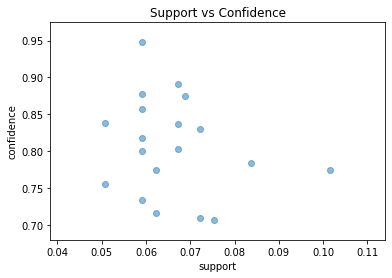

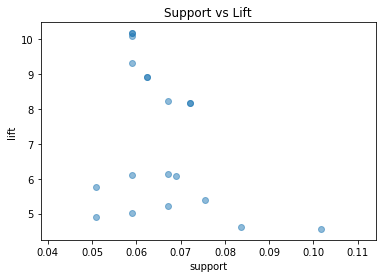

C:\Users\15eth\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\15eth\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\15eth\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


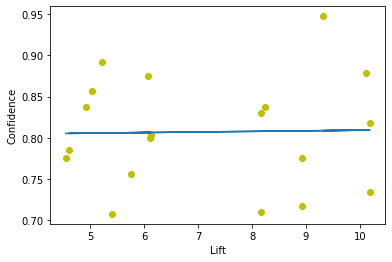

In [70]:
print(rules['antecedents'], rules['consequents'])


plt.scatter(rules['support'], rules['confidence'], alpha=0.5)
plt.xlabel('support')
plt.ylabel('confidence')
plt.title('Support vs Confidence')
plt.show()

plt.scatter(rules['support'], rules['lift'], alpha=0.5)
plt.xlabel('support')
plt.ylabel('lift')
plt.title('Support vs Lift')
plt.show()

fit = np.polyfit(rules['lift'], rules['confidence'], 1)
fit_fn = np.poly1d(fit)
plt.xlabel('Lift')
plt.ylabel('Confidence')
plt.plot(rules['lift'], rules['confidence'], 'yo', rules['lift'], 
fit_fn(rules['lift']))

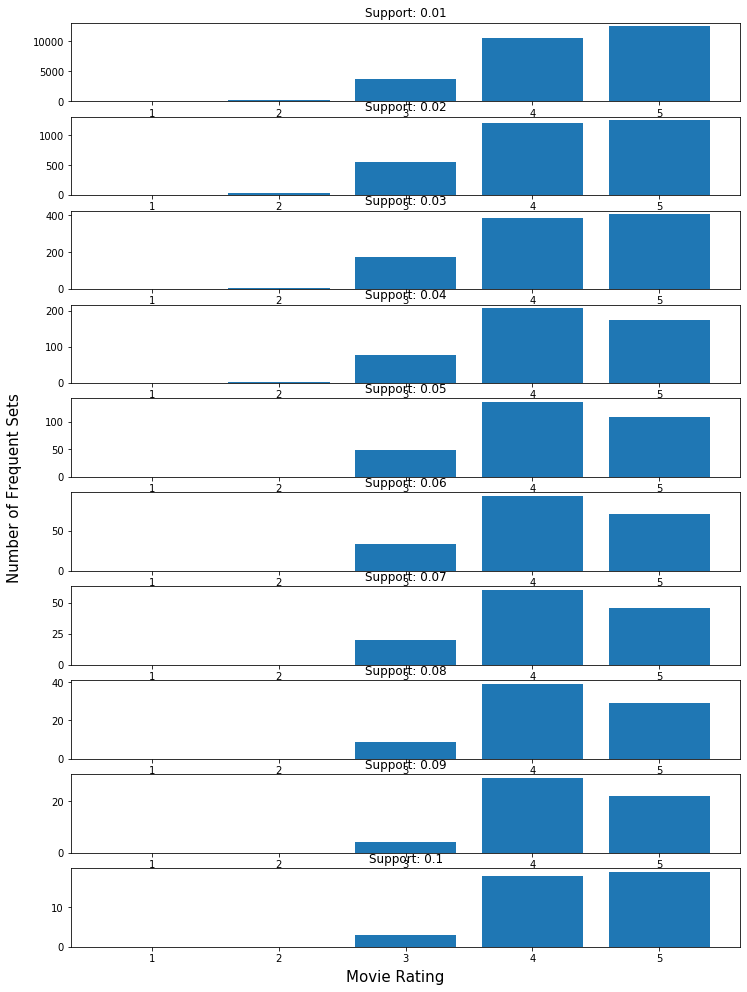

In [64]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth
import pickle_manager
from mlxtend.frequent_patterns import association_rules

#Load data into item sets
df = pickle_manager.load_pickle("..\pickles\organised_ratings.pickle.lz4")


fig, axs = plt.subplots(10,figsize=(12,17))
fig.text(0.5, 0.1, 'Movie Rating', ha='center', va='center', fontsize=15)
fig.text(0.06, 0.5, 'Number of Frequent Sets', ha='center', va='center', rotation='vertical', fontsize=15)

for y in range(1,11):
    resultsX1 = []
    resultsY1 = []
    for x in range(1,6):
       # print("Movie Rating: ", x)
        dataSet = []
        for i in range(1,df['userId'].max()+1):
            itemSet = df.loc[(df['rating'] == x) & (df['userId'] == i)]['imdbId'].tolist()
            dataSet.insert(0,itemSet)
        #Transform the data into the correct format for the libary
        te = TransactionEncoder()
        te_ary = te.fit(dataSet).transform(dataSet)
        new_df = pd.DataFrame(te_ary, columns=te.columns_)
        #Find the frequent pattern sets and generate the assoication rules
        support = 0.01*y
        #print("Support Percentage", support)
        frequent_itemsets = fpgrowth(new_df, min_support=support,use_colnames=True)
        #print("Number of frequent sets:", len(frequent_itemsets))
        resultsY1.insert(len(resultsY1),len(frequent_itemsets))
        resultsX1.insert(len(resultsY1),str(x))
        if(len(frequent_itemsets) > 0):
            rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.7)
            #print("Number of rules:", len(rules))
    axs[y-1].bar(resultsX1, resultsY1)
    axs[y-1].title.set_text("Support: " + str(support))

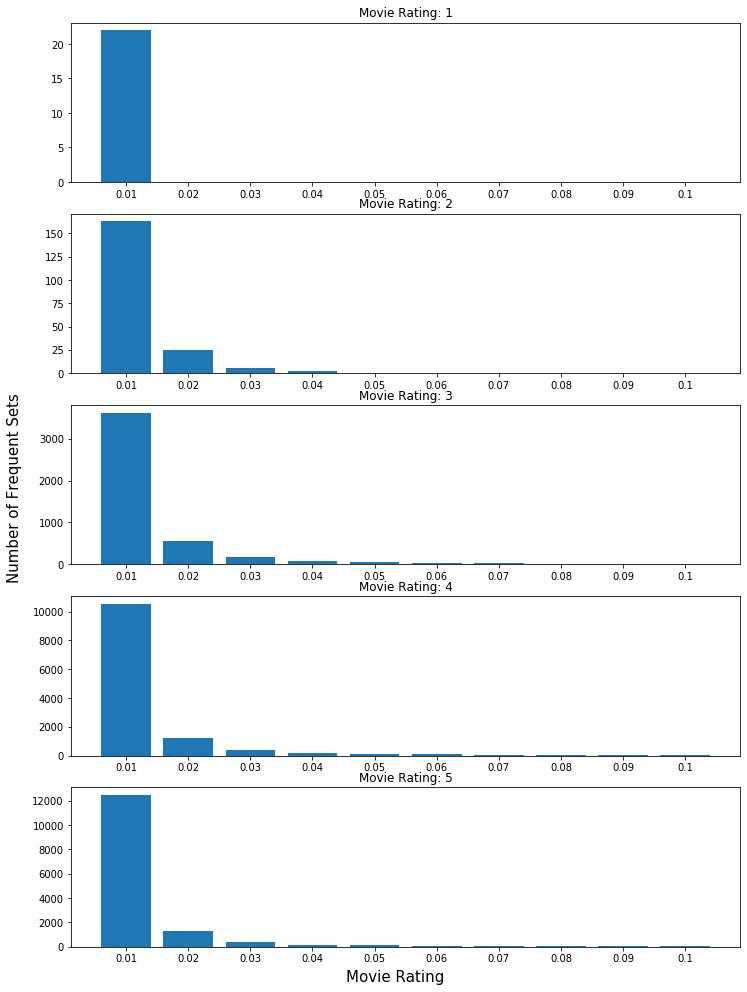

In [71]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth
import pickle_manager
from mlxtend.frequent_patterns import association_rules

#Load data into item sets
df = pickle_manager.load_pickle("..\pickles\organised_ratings.pickle.lz4")


fig, axs = plt.subplots(5,figsize=(12,17))
fig.text(0.5, 0.1, 'Movie Rating', ha='center', va='center', fontsize=15)
fig.text(0.06, 0.5, 'Number of Frequent Sets', ha='center', va='center', rotation='vertical', fontsize=15)

for x in range(1,6):
    resultsX1 = []
    resultsY1 = []
    for y in range(1,11):
       # print("Movie Rating: ", x)
        dataSet = []
        for i in range(1,df['userId'].max()+1):
            itemSet = df.loc[(df['rating'] == x) & (df['userId'] == i)]['imdbId'].tolist()
            dataSet.insert(0,itemSet)
        #Transform the data into the correct format for the libary
        te = TransactionEncoder()
        te_ary = te.fit(dataSet).transform(dataSet)
        new_df = pd.DataFrame(te_ary, columns=te.columns_)
        #Find the frequent pattern sets and generate the assoication rules
        support = 0.01*y
        #print("Support Percentage", support)
        frequent_itemsets = fpgrowth(new_df, min_support=support,use_colnames=True)
        #print("Number of frequent sets:", len(frequent_itemsets))
        resultsY1.insert(len(resultsY1),len(frequent_itemsets))
        resultsX1.insert(len(resultsY1),str(0.01*y))
        if(len(frequent_itemsets) > 0):
            rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.7)
            #print("Number of rules:", len(rules))
    axs[x-1].bar(resultsX1, resultsY1)
    axs[x-1].title.set_text("Movie Rating: " + str(x))

Comparison of custom implementation to mlxtend library


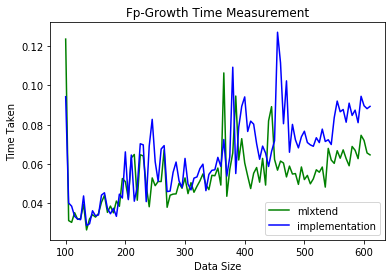

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

df_library = pd.read_csv("../Library.csv")
df_implementation = pd.read_csv("../Implementation.csv")


x1 = np.array(df_library['Dataset Size'])
m=6
x1 = x1.reshape(-1, m).mean(axis=1)
x2 = np.array(df_implementation['Dataset Size'])
x2 = x2.reshape(-1, m).mean(axis=1)

y1 = np.array(df_library['Time Taken'])
y1 = y1.reshape(-1, m).mean(axis=1)
y2 = np.array(df_implementation['Time Taken'])
y2 = y2.reshape(-1, m).mean(axis=1)

print("Comparison of custom implementation to mlxtend library")
plt.plot(x1, y1, '-g', label='mlxtend')
plt.plot(x2, y2, '-b', label='implementation')

plt.title("Fp-Growth Time Measurement")
plt.xlabel("Data Size")
plt.ylabel("Time Taken")
plt.legend(loc='best')